Análisis de sentimientos usando una RNN
===

* *30 min* | Última modificación: Abril 6, 2020.

Basado en https://www.tensorflow.org/tutorials/text/text_classification_rnn

## Importación de librerías

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])
    plt.show()

## Input pipeline

Ver [TFDS](https://www.tensorflow.org/datasets).

In [3]:
dataset, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)
train_examples, test_examples = dataset["train"], dataset["test"]

In [4]:
#
#  El encoder está incluido en el dataset
#
encoder = info.features["text"].encoder

In [5]:
print("Vocabulary size: {}".format(encoder.vocab_size))

Vocabulary size: 8185


In [6]:
#
#  Ejemplo del encoder
#
sample_string = "Hello TensorFlow."

encoded_string = encoder.encode(sample_string)
print("Encoded string is {}".format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [9]:
#
#  Ejemplo de la transformación
#
for index in encoded_string:
    print("{} ----> {}".format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Preparación del dataset

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_examples.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([None], [])
)

test_dataset = test_examples.padded_batch(BATCH_SIZE, padded_shapes=([None], []))

## Creación y compilación del modelo (red LSTM)

In [9]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(encoder.vocab_size, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"],
)

## Entrenamiento

In [10]:
history = model.fit(
    train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 806s 2s/step - loss: 0.6555 - accuracy: 0.5534 - val_loss: 0.5184 - val_accuracy: 0.7833
Epoch 2/10
391/391 [==============================] - 759s 2s/step - loss: 0.3491 - accuracy: 0.8532 - val_loss: 0.3314 - val_accuracy: 0.8703
Epoch 3/10
391/391 [==============================] - 779s 2s/step - loss: 0.2466 - accuracy: 0.9057 - val_loss: 0.3187 - val_accuracy: 0.8672
Epoch 4/10
391/391 [==============================] - 721s 2s/step - loss: 0.2057 - accuracy: 0.9246 - val_loss: 0.3430 - val_accuracy: 0.8693
Epoch 5/10
391/391 [==============================] - 714s 2s/step - loss: 0.1791 - accuracy: 0.9369 - val_loss: 0.3380 - val_accuracy: 0.8776
Epoch 6/10
391/391 [==============================] - 729s 2s/step - loss: 0.1619 - accuracy: 0.9424 - val_loss: 0.3608 - val_accuracy: 0.8708
Epoch 7/10
391/391 [==============================] - 740s 2s/step - loss: 0.1440 - accuracy: 0.9498 - val_loss: 0.3817 - val_accuracy: 0.8745

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

    391/Unknown - 220s 563ms/step - loss: 0.4305 - accuracy: 0.8464Test Loss: 0.43046614287606894
Test Accuracy: 0.8464000225067139


In [20]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [21]:
def sample_predict(sample_pred_text, pad):

    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return predictions

In [22]:
#
#  Pronóstico sobre un texto de ejemplo
#
sample_pred_text = (
    "The movie was cool. The animation and the graphics "
    "were out of this world. I would recommend this movie."
)

sample_predict(sample_pred_text, pad=False)

array([[-0.24062105]], dtype=float32)

In [23]:
#
#  Pronóstico sobre un texto de ejemplo con padding
#
sample_pred_text = (
    "The movie was cool. The animation and the graphics "
    "were out of this world. I would recommend this movie."
)

sample_predict(sample_pred_text, pad=True)

array([[-0.16850393]], dtype=float32)

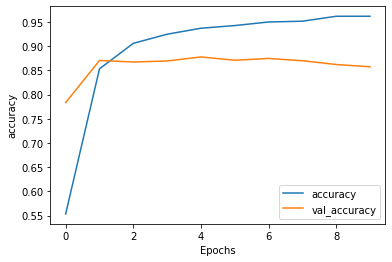

In [24]:
plot_graphs(history, "accuracy")

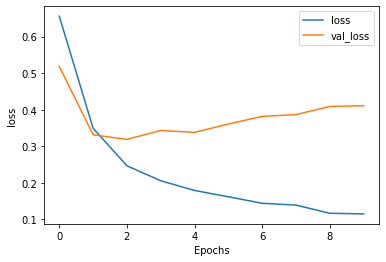

In [25]:
plot_graphs(history, "loss")

## Apilamiento de capas LSTM

In [26]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(encoder.vocab_size, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1),
    ]
)

In [27]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"],
)

In [28]:
history = model.fit(
    train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 1456s 4s/step - loss: 0.6329 - accuracy: 0.5701 - val_loss: 0.4634 - val_accuracy: 0.8068
Epoch 2/10
391/391 [==============================] - 1392s 4s/step - loss: 0.3501 - accuracy: 0.8574 - val_loss: 0.3603 - val_accuracy: 0.8510
Epoch 3/10
391/391 [==============================] - 1388s 4s/step - loss: 0.2545 - accuracy: 0.9091 - val_loss: 0.3519 - val_accuracy: 0.8620
Epoch 4/10
391/391 [==============================] - 1386s 4s/step - loss: 0.2094 - accuracy: 0.9312 - val_loss: 0.3593 - val_accuracy: 0.8609
Epoch 5/10
 13/391 [..............................] - ETA: 27:53 - loss: 0.1694 - accuracy: 0.9518

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

In [ ]:
#
#  Pronóstico de un texto de ejemplo sin padding
#
sample_pred_text = (
    "The movie was not good. The animation and the graphics "
    "were terrible. I would not recommend this movie."
)

sample_predict(sample_pred_text, pad=False)

In [ ]:
#
#  Pronóstico de un texto de ejemplo con padding
#
sample_pred_text = (
    "The movie was not good. The animation and the graphics "
    "were terrible. I would not recommend this movie."
)

sample_predict(sample_pred_text, pad=True)

In [ ]:
plot_graphs(history, "accuracy")

In [ ]:
plot_graphs(history, "loss")